In [ ]:
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


### PIP Installs

In [ ]:
pip install geopy


In [ ]:
pip install --upgrade openai

### Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import model_selection,tree
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error,r2_score
import itertools
import re
from geopy.geocoders import  Photon
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium.plugins import HeatMap
from enum import Enum
import geopandas as gpd
import geopy
import geocoder
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import datetime

# from geopy.geocoders import Nominatim


### Load Dataset -


In [ ]:
# Define the path to the CSV file containing CitySafe insights data
csv_path = '/content/drive/My Drive/Datasets/FDS/FinalProject/Geospatial_Analysis_cleaned_dataset.csv'

# Read the CSV file into a Pandas DataFrame, remove duplicate entries
mv_df = pd.read_csv(csv_path).drop_duplicates()


In [ ]:
mv_df.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'STRTNAME_BOROUGH', 'Neighboorhood'],
      dtype='object')

### Some Visualizations on the dataset

In [ ]:
# Display the first few rows of the DataFrame to inspect the data
print(mv_df.head())

   CRASH DATE CRASH TIME   BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
3  09/11/2021       9:35  BROOKLYN   11208.0  40.667202 -73.866500   
4  12/14/2021       8:13  BROOKLYN   11233.0  40.683304 -73.917274   
6  12/14/2021      17:05       NaN       NaN  40.709183 -73.956825   
7  12/14/2021       8:17     BRONX   10475.0  40.868160 -73.831480   
8  12/14/2021      21:10  BROOKLYN   11207.0  40.671720 -73.897100   

                LOCATION                                     ON STREET NAME  \
3    40.667202, -73.8665                                                NaN   
4  40.683304, -73.917274      SARATOGA AVENUE NYC,  NEW YORK NYC,  New York   
6  40.709183, -73.956825  BROOKLYN QUEENS EXPRESSWAY NYC,  NEW YORK NYC,...   
7    40.86816, -73.83148                                                NaN   
8     40.67172, -73.8971                                                NaN   

  CROSS STREET NAME              OFF STREET NAME  ...  \
3               NaN      1211      LORING AVENU

In [ ]:
# Output concise summary information about the DataFrame structure
# including column names, non-null count, and data types
print(mv_df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1833472 entries, 3 to 2034304
Data columns (total 31 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       float64
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [ ]:
# Output the dimensions (rows, columns) of the DataFrame
print(mv_df.shape)

(1833472, 31)


In [ ]:
# Output the column names present in the DataFrame
print(mv_df.columns)


Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'STRTNAME_BOROUGH', 'Neighboorhood'],
      dtype='object')


In [ ]:
# Generate and print summary statistics of the numerical columns in the DataFrame
print(mv_df.describe())


           ZIP CODE      LATITUDE     LONGITUDE  NUMBER OF PERSONS INJURED  \
count  1.394809e+06  1.833472e+06  1.833472e+06               1.833456e+06   
mean   1.084026e+04  4.062955e+01 -7.375505e+01               3.058857e-01   
std    5.574868e+02  1.966387e+00  3.705180e+00               6.923928e-01   
min    0.000000e+00 -4.590335e+01 -2.013600e+02               0.000000e+00   
25%    1.030700e+04  4.066807e+01 -7.397495e+01               0.000000e+00   
50%    1.120700e+04  4.072132e+01 -7.392783e+01               0.000000e+00   
75%    1.123700e+04  4.076998e+01 -7.386731e+01               0.000000e+00   
max    1.169700e+04  5.338986e+01  1.704921e+02               4.300000e+01   

       NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
count              1.833444e+06                   1.833472e+06   
mean               1.441549e-03                   5.807997e-02   
std                4.009317e-02                   2.471931e-01   
min                0.000000e+00  

In [ ]:
# Iterate through each column in the DataFrame.
for col in mv_df.columns:
    # Print the number of unique values for each column.
    print(f"Number of unique values of {col} is: {mv_df[col].nunique()}")


Number of unique values of CRASH DATE is: 4123
Number of unique values of CRASH TIME is: 1440
Number of unique values of BOROUGH is: 5
Number of unique values of ZIP CODE is: 234
Number of unique values of LATITUDE is: 127333
Number of unique values of LONGITUDE is: 99354
Number of unique values of LOCATION is: 278084
Number of unique values of ON STREET NAME is: 8400
Number of unique values of CROSS STREET NAME is: 16664
Number of unique values of OFF STREET NAME is: 201355
Number of unique values of NUMBER OF PERSONS INJURED is: 30
Number of unique values of NUMBER OF PERSONS KILLED is: 7
Number of unique values of NUMBER OF PEDESTRIANS INJURED is: 14
Number of unique values of NUMBER OF PEDESTRIANS KILLED is: 4
Number of unique values of NUMBER OF CYCLIST INJURED is: 5
Number of unique values of NUMBER OF CYCLIST KILLED is: 3
Number of unique values of NUMBER OF MOTORIST INJURED is: 29
Number of unique values of NUMBER OF MOTORIST KILLED is: 6
Number of unique values of CONTRIBUTING

## Creating Global Helper Function

In [ ]:
class HelperClass:
  """Helper class containing various static methods for data manipulation."""

  @staticmethod
  def create_csv_from_dataframe(df, file_name):
    """Save DataFrame to CSV file without index.
        Args:
            df (DataFrame): The DataFrame to be saved.
            file_name (str): Name of the output CSV file.
    """
    try:
        df.to_csv(file_name, index=False)
        print(f"DataFrame successfully saved as '{file_name}'")
    except Exception as e:
        print(f"An error occurred: {e}")


  @staticmethod
  def extract_latlong_from_location(location_str, want_latitude:bool):
    """Extract latitude or longitude from a location string.

        Args:
            location_str (str): String containing latitude and longitude.
            want_latitude (bool): True for latitude, False for longitude.

        Returns:
            str: Extracted latitude or longitude string.
    """
    if location_str and not pd.isnull(location_str):
      lstr  = str(location_str)
      lat, longi = lstr.split(',')
      return lat.strip() if want_latitude  else longi.strip()
    else:
      return location_str

  @staticmethod
  def dataframe2csv(mv_df, fileName):
    """Save DataFrame to CSV file without index.

        Args:
            mv_df (DataFrame): The DataFrame to be saved.
            file_name (str): Name of the output CSV file.
    """
    fn = f'{fileName}.csv'
    # mv_df = pd.read_csv(csv_path).drop_duplicates()
    mv_df.to_csv(fn, index=False)


  @staticmethod
  def plot_map(df,filename ="f"):
    """Generate and save a map visualization.

        Args:
            df (DataFrame): DataFrame containing location data.
            filename (str): Name of the output HTML file.

        Returns:
            Map: Generated Folium map object.
    """
    BASE_LAT_NYC  = 40.7128

    BASE_LONG_NYC = -73.935242

    nyc_map = folium.Map(location=[BASE_LAT_NYC, BASE_LONG_NYC ], zoom_start=11)

    heat_data = [[point['LATITUDE'], point['LONGITUDE'], point[HelperClass.CrashColumns.STRTNAME_BOROUGH.value]] for index, point in df.iterrows() ]
    for index, row in enumerate(heat_data):
      folium.Marker(row[:2], popup = row[2]).add_to(nyc_map)
    nyc_map.save(f'{filename}_{datetime.datetime.now()}.html')
    return nyc_map

  class CrashColumns(Enum):
    """Enum for crash columns."""

    CRASH_DATE = 'CRASH DATE'
    CRASH_TIME = 'CRASH TIME'
    BOROUGH = 'BOROUGH'
    ZIP_CODE = 'ZIP CODE'
    LATITUDE = 'LATITUDE'
    LONGITUDE = 'LONGITUDE'
    LOCATION = 'LOCATION'
    ON_STREET_NAME = 'ON STREET NAME'
    CROSS_STREET_NAME = 'CROSS STREET NAME'
    OFF_STREET_NAME = 'OFF STREET NAME'
    NUMBER_OF_PERSONS_INJURED = 'NUMBER OF PERSONS INJURED'
    NUMBER_OF_PERSONS_KILLED = 'NUMBER OF PERSONS KILLED'
    NUMBER_OF_PEDESTRIANS_INJURED = 'NUMBER OF PEDESTRIANS INJURED'
    NUMBER_OF_PEDESTRIANS_KILLED = 'NUMBER OF PEDESTRIANS KILLED'
    NUMBER_OF_CYCLIST_INJURED = 'NUMBER OF CYCLIST INJURED'
    NUMBER_OF_CYCLIST_KILLED = 'NUMBER OF CYCLIST KILLED'
    NUMBER_OF_MOTORIST_INJURED = 'NUMBER OF MOTORIST INJURED'
    NUMBER_OF_MOTORIST_KILLED = 'NUMBER OF MOTORIST KILLED'
    CONTRIBUTING_FACTOR_VEHICLE_1 = 'CONTRIBUTING FACTOR VEHICLE 1'
    CONTRIBUTING_FACTOR_VEHICLE_2 = 'CONTRIBUTING FACTOR VEHICLE 2'
    CONTRIBUTING_FACTOR_VEHICLE_3 = 'CONTRIBUTING FACTOR VEHICLE 3'
    CONTRIBUTING_FACTOR_VEHICLE_4 = 'CONTRIBUTING FACTOR VEHICLE 4'
    CONTRIBUTING_FACTOR_VEHICLE_5 = 'CONTRIBUTING FACTOR VEHICLE 5'
    COLLISION_ID = 'COLLISION_ID'
    VEHICLE_TYPE_CODE_1 = 'VEHICLE TYPE CODE 1'
    VEHICLE_TYPE_CODE_2 = 'VEHICLE TYPE CODE 2'
    VEHICLE_TYPE_CODE_3 = 'VEHICLE TYPE CODE 3'
    VEHICLE_TYPE_CODE_4 = 'VEHICLE TYPE CODE 4'
    VEHICLE_TYPE_CODE_5 = 'VEHICLE TYPE CODE 5'
    STRTNAME_BOROUGH = 'STRTNAME_BOROUGH'
    NEIGHBORHOOD = 'Neighboorhood'


  class NYC_Boroughs(Enum):
    """Enum for New York City boroughs."""
    MANHATTAN = 'MANHATTAN'
    BRONX = 'BRONX'
    BROOKLYN = 'BROOKLYN'
    QUEENS = 'QUEENS'
    STATEN_ISLAND = 'STATEN ISLAND'



## Task: Creating New Columns

###  Creating a "Neighborhood" column to generate refined plots on a neighborhood basis.

In [ ]:
# Define the path to the CSV file containing NYC zip code data
csv_path = '/content/drive/My Drive/Datasets/FDS/FinalProject/nyc-zip-codes.csv'

# Read the CSV file into a Pandas DataFrame, removing duplicate entries
zip_nei_df = pd.read_csv(csv_path).drop_duplicates()


In [ ]:
# Convert the 'ZipCode' column in the DataFrame to string type
zip_nei_df['ZipCode'] = zip_nei_df['ZipCode'].astype(str)


In [ ]:
# Create a dictionary mapping zip codes to neighborhoods
zip_neighborhood_dict = dict(zip(zip_nei_df['ZipCode'], zip_nei_df['Neighborhood']))


In [ ]:
# Assign neighborhoods based on ZIP codes using a dictionary lookup
mv_df['Neighborhood'] = mv_df.apply(lambda row: zip_neighborhood_dict[row['ZIP CODE']] if row['ZIP CODE'] in zip_neighborhood_dict else np.nan, axis=1)


In [ ]:
print(mv_df['Neighboorhood'])

0                                    NaN
1                                    NaN
2                                    NaN
3             East New York and New Lots
4                       Central Brooklyn
                       ...              
2034300                              NaN
2034301    Gramercy Park and Murray Hill
2034302                          Jamaica
2034303                              NaN
2034304                              NaN
Name: Neighboorhood, Length: 2034305, dtype: object


In [ ]:
# HelperClass.dataframe2csv(mv_df,"CitySafe_Insights_v1")

## Task: Data Cleaning

#### Making sure date is in: mm/dd/yyyy format

In [ ]:
print(mv_df['CRASH DATE'].unique())

['09/11/2021' '03/26/2022' '06/29/2022' ... '08/19/2023' '03/19/2023'
 '04/15/2023']


In [ ]:
# date_pattern = r'(\d{2}-\d{2}-\d{4})'
date_pattern = r'(\d{2}-\d{2}-\d{4})'

# Extract dates in mm-dd-yyyy format
mm_dd_yyyy_dates = mv_df['CRASH DATE'].str.extract(date_pattern)

print('mm_dd_yyyy_dates',mm_dd_yyyy_dates[0].unique())

# Filter out rows where the pattern matched
mm_dd_yyyy_dates = mm_dd_yyyy_dates.dropna()

# Print the unique dates in mm-dd-yyyy format
unique_dates = mm_dd_yyyy_dates[0].unique()
print(unique_dates)

mm_dd_yyyy_dates [nan]
[]


In [ ]:
# automatically converted to mm/dd/yyyy format

#### P2: Standardizing the data values

In [ ]:
# Convert 'ON STREET NAME' column strings to uppercase
# and remove leading/trailing whitespaces for consistency.
mv_df['ON STREET NAME'] = mv_df['ON STREET NAME'].str.upper().str.strip()

In [ ]:
# Append 'NYC, New York' to the 'ON STREET NAME' column for location information.
mv_df['ON STREET NAME'] = mv_df['ON STREET NAME'] + " NYC, " + " New York"


In [ ]:
print(mv_df['ON STREET NAME'])

0          WHITESTONE EXPRESSWAY NYC,  NEW YORK NYC,  NEW...
1          QUEENSBORO BRIDGE UPPER NYC,  NEW YORK NYC,  N...
2          THROGS NECK BRIDGE NYC,  NEW YORK NYC,  NEW YO...
3                                                        NaN
4          SARATOGA AVENUE NYC,  NEW YORK NYC,  NEW YORK ...
                                 ...                        
2034300    NORTHERN BOULEVARD NYC,  NEW YORK NYC,  NEW YO...
2034301    WEST 27 STREET NYC,  NEW YORK NYC,  NEW YORK N...
2034302    JAMAICA AVENUE NYC,  NEW YORK NYC,  NEW YORK N...
2034303    EAST TREMONT AVENUE NYC,  NEW YORK NYC,  NEW Y...
2034304    6 AVENUE NYC,  NEW YORK NYC,  NEW YORK NYC,  N...
Name: ON STREET NAME, Length: 2034305, dtype: object


In [ ]:
# Grouping DataFrame by 'ON STREET NAME' to count occurrences.
# Creating a new DataFrame 'street_counts' to store street names and their respective counts.
street_counts = mv_df.groupby('ON STREET NAME').size().reset_index(name='COUNT')

# Printing the resulting DataFrame containing street names and their counts.
print(street_counts)


                                          ON STREET NAME  COUNT
0      1 278 ROBERT F KENNEDY BRIDGE N/ NYC,  NEW YOR...      1
1      1 900 G ROBERT F KENNEDY BRIDGE NYC,  NEW YORK...      1
2      1 AVENUE NYC,  NEW YORK NYC,  NEW YORK NYC,  N...   6317
3      1 BEARD STREET NYC,  NEW YORK NYC,  NEW YORK N...      1
4      1 CENTRE AVENUE NYC,  NEW YORK NYC,  NEW YORK ...      1
...                                                  ...    ...
10384  ZOLLER ROAD NYC,  NEW YORK NYC,  NEW YORK NYC,...     12
10385  ZOO PATH NYC,  NEW YORK NYC,  NEW YORK NYC,  N...      1
10386  ZULETTE AVENUE NYC,  NEW YORK NYC,  NEW YORK N...     68
10387  ZWICKY AVENUE NYC,  NEW YORK NYC,  NEW YORK NY...      4
10388  ESTFARMS ROAD NYC,  NEW YORK NYC,  NEW YORK N...      1

[10389 rows x 2 columns]


In [ ]:
# Replace 'AVE' with 'AVENUE' in 'ON STREET NAME' column using regex pattern matching.
mv_df['ON STREET NAME'] = mv_df['ON STREET NAME'].str.replace(r'\bAVE\b', 'AVENUE', regex=True)


In [ ]:
# Counting occurrences of unique street names in 'ON STREET NAME' column.
# Creating a DataFrame 'street_counts' with street names and their respective counts.
street_counts = mv_df.groupby('ON STREET NAME').size().reset_index(name='COUNT')

# Displaying the DataFrame containing street names and their counts.
print(street_counts)


                                          ON STREET NAME  COUNT
0      1 278 ROBERT F KENNEDY BRIDGE N/ NYC,  NEW YOR...      1
1      1 900 G ROBERT F KENNEDY BRIDGE NYC,  NEW YORK...      1
2      1 AVENUE NYC,  NEW YORK NYC,  NEW YORK NYC,  N...   6317
3      1 BEARD STREET NYC,  NEW YORK NYC,  NEW YORK N...      1
4      1 CENTRE AVENUE NYC,  NEW YORK NYC,  NEW YORK ...      1
...                                                  ...    ...
10384  ZOLLER ROAD NYC,  NEW YORK NYC,  NEW YORK NYC,...     12
10385  ZOO PATH NYC,  NEW YORK NYC,  NEW YORK NYC,  N...      1
10386  ZULETTE AVENUE NYC,  NEW YORK NYC,  NEW YORK N...     68
10387  ZWICKY AVENUE NYC,  NEW YORK NYC,  NEW YORK NY...      4
10388  ESTFARMS ROAD NYC,  NEW YORK NYC,  NEW YORK N...      1

[10389 rows x 2 columns]


In [ ]:
print(street_counts['COUNT'].sum())

1605059


#### Standardizing the Location column - converting the latitude and longitude string format for use in reverse geocoding.

In [ ]:
mask = mv_df[HelperClass.CrashColumns.LOCATION.value].notna()
mv_df.loc[mask, HelperClass.CrashColumns.LOCATION.value] = mv_df.loc[mask, HelperClass.CrashColumns.LOCATION.value].str.replace(r'[()]', '', regex=True)

In [ ]:
mv_df[HelperClass.CrashColumns.LOCATION.value].head()

0                      NaN
1                      NaN
2                      NaN
3      40.667202, -73.8665
4    40.683304, -73.917274
Name: LOCATION, dtype: object

### Standardize - ZipCode Column

In [ ]:
# Creating a mask to filter rows with non-null and non-empty values in a specific column.
mask = (
    mv_df[HelperClass.CrashColumns.ZIP_CODE.value].notnull() &
    mv_df[HelperClass.CrashColumns.ZIP_CODE.value].notna() &
    (mv_df[HelperClass.CrashColumns.ZIP_CODE.value] != '')
)

# Accessing the 'ZIP CODE' column for rows matching the mask criteria.
mv_df[mask]['ZIP CODE']


NameError: ignored

In [ ]:
def standardize_zip(zip_code):
    """
    Standardizes the input ZIP code.

    Args:
    - zip_code (str or int): The ZIP code to be standardized.

    Returns:
    - str: Standardized 5-digit ZIP code if valid, otherwise NaN.

    Example:
    standardize_zip('12345')  # Output: '12345'
    """

    if pd.isnull(zip_code) or zip_code == '':
        return np.nan  # Preserve NaN or empty values

    zip_str = str(zip_code)  # Convert to string
    zip_str = ''.join(filter(str.isdigit, zip_str))  # Remove non-digits
    zip_str = zip_str.zfill(5)  # Ensure 5-digit format

    return zip_str[:5]  # Return the first 5 characters


In [ ]:
# Applying the 'standardize_zip' function to the 'ZIP CODE' column for data standardization.
mv_df['ZIP CODE'] = mv_df['ZIP CODE'].apply(standardize_zip)


In [ ]:
mv_df['ZIP CODE']

0            NaN
1            NaN
2            NaN
3          11208
4          11233
           ...  
2034300      NaN
2034301    10016
2034302    11433
2034303      NaN
2034304      NaN
Name: ZIP CODE, Length: 2034305, dtype: object

## Task: Handle Missing Data

#### pre-analysis

In [ ]:
# Identifying missing values in the DataFrame 'mv_df'.
missing_values = mv_df.isna()

# Counting the number of missing values for each column.
missing_values_count = missing_values.sum()

# Printing the count of missing values for each column.
print(missing_values_count)


CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           632860
ZIP CODE                          633101
LATITUDE                          230897
LONGITUDE                         230897
LOCATION                          230897
ON STREET NAME                    429246
CROSS STREET NAME                 763650
OFF STREET NAME                  1697432
NUMBER OF PERSONS INJURED             18
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       6442
CONTRIBUTING FACTOR VEHICLE 2     311521
CONTRIBUTING FACTOR VEHICLE 3    1889753
CONTRIBUTING FACTOR VEHICLE 4    2001834
CONTRIBUTING FACTOR VEHICLE 5    2025517
COLLISION_ID                           0
VEHICLE TYPE COD

In [ ]:
# Filtering rows with missing or empty 'LOCATION' data and capturing associated 'CRASH DATE'.
dates_with_missing_location = mv_df[mv_df['LOCATION'].isna() | (mv_df['LOCATION'] == ' ')]['CRASH DATE']


In [ ]:
print(dates_with_missing_location)

0          09/11/2021
1          03/26/2022
2          06/29/2022
5          04/14/2021
12         12/14/2021
              ...    
2034258    09/18/2023
2034266    09/19/2023
2034271    09/19/2023
2034272    08/26/2023
2034294    09/15/2023
Name: CRASH DATE, Length: 230897, dtype: object


In [ ]:
# initialize Nominatim API
geolocator = Photon(user_agent="geoapiExercises-FDSPROJ")


In [ ]:
count = 0

# Iterating through non-null latitude and longitude pairs from the DataFrame columns.
for lat, lon in zip(mv_df['LATITUDE'].dropna(), mv_df['LONGITUDE'].dropna()):
    print(lat, lon)  # Printing latitude and longitude
    count += 1

    # Breaking the loop after printing 20 pairs of latitude and longitude
    if count == 20:
        break

    # Reverse geocoding to obtain address using latitude and longitude
    addr = geolocator.reverse(f"{lat},{lon}")
    print(addr)  # Printing the address

    # Geocoding to obtain location details using the address
    location = geolocator.geocode(addr)
    print(location)  # Printing the location details
    print("\n\n")  # Adding separation between iterations


40.667202 -73.8665


Loring Avenue, 11414;11208, New York, New York, United States
New York, New York, United States



40.683304 -73.917274
645, Decatur Street, 11233, Decatur Street, New York, New York, United States
645, Decatur Street, 11233, Decatur Street, New York, New York, United States



40.709183 -73.956825
Marcy Green Center, United States
Marcy Green Center, United States



40.86816 -73.83148


Baychester Avenue, 10475, New York, New York, United States
Baychester Avenue, 10475, New York, New York, United States



40.67172 -73.8971
2052, Pitkin Avenue, 11207, Pitkin Avenue, New York, New York, United States
2052, Pitkin Avenue, 11207, Pitkin Avenue, New York, New York, United States



40.75144 -73.97397
Pita Yeero, 684, 3rd Avenue, 10017, 3rd Avenue, New York, NY, United States
Pita Yeero, 684, 3rd Avenue, 10017, 3rd Avenue, New York, NY, United States



40.701275 -73.88887
Evertz's Cafe Restaurant, 65-53, Myrtle Avenue, 11385, Myrtle Avenue, New York, NY, United States
Evertz's Cafe Restaurant, 65-53, Myrtle Avenue, 11385, Myrtle Avenue, New York, NY, United States



40.675884 -73.75577
Eastgate Plaza, 11413, New York, New York, United States
Eastgate Plaza, 11413, New York, New York, United States



40.59662 -74.00231
Belt Parkway Bike Path, 11214, New York, New York, United States
Belt Parkway Bike Path, 11214, New York, New York, United States



40.66684 -73.78941
1

In [ ]:
addr = 'MAJOR DEEGAN EXPRESSWAY RAMP'

# Geocoding to obtain location details for the given address.
location = geolocator.geocode(addr)

# Printing the complete address and its corresponding latitude and longitude.
print(location)
print(location.latitude, location.longitude)


Major Deegan Expressway, 10470, New York, New York, United States
40.8969788 -73.8803695


### Imputing the zip code using ON STREET NAME

#### Helper functions

In [ ]:
def extract_zip_code(address):
    """
    Extracts the ZIP code from the given address string.

    Args:
    - address (str): The address string containing the ZIP code.

    Returns:
    - str or NaN: Extracted 5-digit ZIP code if found, otherwise NaN.

    Example:
    extract_zip_code('Sample address with 12345 ZIP code')  # Output: '12345'
    """

    pattern = r'\b\d{5}\b'  # Regular expression pattern for a 5-digit ZIP code

    # Search for the ZIP code pattern in the address string
    match = re.search(pattern, str(address))

    if match:
        zip_code = match.group()  # Retrieve the matched ZIP code
        return zip_code
    else:
        return np.nan  # Return NaN if no ZIP code is found


#### Imputing the zip code only if it's null using street address

In [ ]:
# Filtering rows where 'ZIP CODE' is NaN and 'ON STREET NAME' is not NaN.
mv_df[mv_df['ZIP CODE'].isna() & mv_df['ON STREET NAME'].notna()]


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
61,04/24/2022,10:27,NaN,NaN,NaN,NaN,NaN,"VANWYCK EXPRESSWAY NYC, New York",109 AVENUE,NaN,...,Traffic Control Disregarded,NaN,NaN,NaN,4521902,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
76,12/09/2021,8:00,NaN,NaN,40.569626,-74.190735,"(40.569626, -74.190735)","WEST SHORE EXPRESSWAY NYC, New York",NaN,NaN,...,Unspecified,NaN,NaN,NaN,4485214,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
120,12/16/2021,9:23,NaN,NaN,NaN,NaN,NaN,"JACKIE ROBINSON EXPY NYC, New York",JAMAICA AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4487185,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN
124,03/26/2022,1:26,NaN,NaN,NaN,NaN,NaN,"GOWANUS RAMP NYC, New York",NaN,NaN,...,Unspecified,NaN,NaN,NaN,4513528,UTILITY,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
168,03/21/2022,19:13,NaN,NaN,40.731407,-73.996980,"(40.731407, -73.99698)","WASHINGTON SQUARE NORTH NYC, New York",NaN,NaN,...,Unspecified,NaN,NaN,NaN,4514234,Sedan,Bike,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033224,09/16/2023,7:25,NaN,NaN,NaN,NaN,NaN,"VANWYCK EXPRESSWAY NYC, New York",JAMAICA AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4662896,Sedan,NaN,NaN,NaN,NaN
2033363,05/09/2023,9:45,NaN,NaN,40.779290,-73.981140,"(40.77929, -73.98114)","WEST 73 STREET NYC, New York",NaN,NaN,...,Unspecified,NaN,NaN,NaN,4631674,Motorcycle,Sedan,NaN,NaN,NaN
2033928,09/17/2023,12:30,NaN,NaN,40.670887,-73.936490,"(40.670887, -73.93649)","SAINT JOHNS PLACE NYC, New York",NaN,NaN,...,NaN,NaN,NaN,NaN,4663926,Sedan,NaN,NaN,NaN,NaN
2034146,09/19/2023,21:39,NaN,NaN,NaN,NaN,NaN,"BRADDOCK AVENUE NYC, New York",CROSS ISLAND PARKWAY,NaN,...,NaN,NaN,NaN,NaN,4663617,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [ ]:
len(mv_df[mv_df['ZIP CODE'].isna() & mv_df['ON STREET NAME'].notna()])

506548

In [ ]:
streets_with_nozipcode = pd.DataFrame({'ON STREET NAME':mv_df[mv_df['ZIP CODE'].isna() & mv_df['ON STREET NAME'].notna()]['ON STREET NAME']})

In [ ]:
print(streets_with_nozipcode)

                                       ON STREET NAME
0                WHITESTONE EXPRESSWAY NYC,  New York
1              QUEENSBORO BRIDGE UPPER NYC,  New York
2                   THROGS NECK BRIDGE NYC,  New York
5         MAJOR DEEGAN EXPRESSWAY RAMP NYC,  New York
6           BROOKLYN QUEENS EXPRESSWAY NYC,  New York
...                                               ...
2034293              FARMERS BOULEVARD NYC,  New York
2034294  STATEN ISLAND EXPRESSWAY RAMP NYC,  New York
2034300             NORTHERN BOULEVARD NYC,  New York
2034303            EAST TREMONT AVENUE NYC,  New York
2034304                       6 AVENUE NYC,  New York

[506548 rows x 1 columns]


In [ ]:
grouped_streets_with_nozipcode = streets_with_nozipcode.groupby('ON STREET NAME').size().reset_index(name='COUNT')


In [ ]:
# Sorting the DataFrame 'grouped_streets_with_nozipcode' by the 'COUNT' column in descending order.
grouped_streets_with_nozipcode = grouped_streets_with_nozipcode.sort_values(by='COUNT', ascending=False)

# Printing the sorted DataFrame.
print(grouped_streets_with_nozipcode)


                                 ON STREET NAME  COUNT
1610                BELT PARKWAY NYC,  New York  17311
4663      LONG ISLAND EXPRESSWAY NYC,  New York  12046
1886  BROOKLYN QUEENS EXPRESSWAY NYC,  New York  12039
3716          GRAND CENTRAL PKWY NYC,  New York  10642
3358                   FDR DRIVE NYC,  New York   9176
...                                         ...    ...
1432            BEACH 104 STREET NYC,  New York      1
1437             BEACH 11 STREET NYC,  New York      1
1448            BEACH 126 STREET NYC,  New York      1
1449            BEACH 127 STREET NYC,  New York      1
7646              ESTFARMS ROAD NYC,  New York      1

[7647 rows x 2 columns]


In [ ]:
# Calculate the number of unique values in each column of the DataFrame 'grouped_streets_with_nozipcode'.
# This method counts the distinct values in each column, excluding NaNs.
unique_values_count = grouped_streets_with_nozipcode.nunique()


ON STREET NAME    7647
COUNT              508
dtype: int64

In [ ]:
len(mv_df[mv_df['ZIP CODE'].isna() & mv_df['ON STREET NAME'].notna()])

506548

#### applying geocode

In [ ]:
# Rate-limiting the geocoding process to one call per second using RateLimiter.
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Applying geocoding to retrieve ZIP code information based on 'ON STREET NAME'.
grouped_streets_with_nozipcode['ZIP CODE'] = grouped_streets_with_nozipcode['ON STREET NAME'].apply(geocode)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 537, in _make_request
    response = conn.getresponse()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 461, in getresponse
    httplib_response = super().getresponse()
  File "/usr/lib/python3.10/http/client.py", line 1375, in getresponse
    response.begin()
  File "/usr/lib/python3.10/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.10/http/client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.10/ssl.py", line 1274, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.10/ssl.py", line 1130, in read
    return self._sslobj.read(len, buffer)
TimeoutError: The read operation timed out

The above e

In [ ]:
excel_file_path = 'your_dataframe.xlsx'

# Export the DataFrame to Excel
grouped_streets_with_nozipcode.to_excel(excel_file_path, index=False)

In [ ]:
print(grouped_streets_with_nozipcode['ZIP CODE'][0])

NYC Department of Sanitation, New York, New York, United States


In [ ]:
len(mv_df[mv_df['ZIP CODE'].isna() & mv_df['ON STREET NAME'].notna()])
# len(mv_df[mv_df['ZIP CODE'].isna() & mv_df['ON STREET NAME'].notna()])

506548

#### Getting zip code from excel (Imputed already)

In [ ]:
csv_path = '/content/drive/My Drive/Datasets/FDS/FinalProject/impute_entireLocation.xlsx'

# Read the CSV file into a Pandas DataFrame
entire_location_df = pd.read_excel(csv_path).drop_duplicates()

In [ ]:
entire_location_df

,ON STREET NAME,COUNT,ZIP CODE
0,"BELT PARKWAY NYC, New York",17311,"Belt Parkway, 11224, New York, New York, Unite..."
1,"LONG ISLAND EXPRESSWAY NYC, New York",12046,"Staten Island Railway, Staten Island Expresswa..."
2,"BROOKLYN QUEENS EXPRESSWAY NYC, New York",12039,"Brooklyn-Queens Expressway, 11104, New York, N..."
3,"GRAND CENTRAL PKWY NYC, New York",10642,"Grand Central Parkway, 11102, New York, New Yo..."
4,"FDR DRIVE NYC, New York",9176,"FDR Drive, 10029, New York, New York, United S..."
...,...,...,...
7642,"BEACH 104 STREET NYC, New York",1,"104, East 126th Street, 10035, East 126th Stre..."
7643,"BEACH 11 STREET NYC, New York",1,"MoMA, 11, West 53rd Street, 10019, West 53rd S..."
7644,"BEACH 126 STREET NYC, New York",1,"Church of The Holy Innocents, 126, West 37th S..."
7645,"BEACH 127 STREET NYC, New York",1,"Gramercy Theatre, 127, East 23rd Street, 10010..."


In [ ]:
len(mv_df['ZIP CODE'].isna())

2034305

In [ ]:
street_zip_map = dict(zip(entire_location_df['ON STREET NAME'], entire_location_df['ZIP CODE']))

In [ ]:
mask = mv_df['ZIP CODE'].isna() & mv_df['ON STREET NAME'].isin(street_zip_map)

# Update the 'ZIP CODE' column where the mask is True using map and fillna
mv_df.loc[mask, 'ZIP CODE'] = mv_df.loc[mask, 'ON STREET NAME'].map(street_zip_map)

In [ ]:
len(mv_df['ZIP CODE'].isna())

2034305

In [ ]:
mask = mv_df['ZIP CODE'].isna() & mv_df['ON STREET NAME'].isin(street_zip_map)

# Use the mask to update the 'ZIP CODE' column with values from the map.
# mv_df.loc[mask, 'ZIP CODE'] = mv_df.loc[mask, 'ON STREET NAME'].map(street_zip_map)
mask = (
    mv_df['ZIP CODE'].isna() &
    mv_df['ON STREET NAME'].str.upper().isin(street.upper() for street in street_zip_map)
)

In [ ]:
mv_df.loc[mask, 'ZIP CODE'] = mv_df.loc[mask, 'ON STREET NAME'].map(street_zip_map)


In [ ]:

location_counts = mv_df['LOCATION'].value_counts().reset_index()
location_counts.columns = ['LOCATION', 'COUNT']

print(location_counts)

                       LOCATION  COUNT
0                    (0.0, 0.0)   4272
1        (40.861862, -73.91282)    685
2       (40.608757, -74.038086)    670
3        (40.696033, -73.98453)    646
4          (40.8047, -73.91243)    597
...                         ...    ...
276665  (40.867058, -73.860374)      1
276666  (40.687126, -73.734215)      1
276667   (40.631638, -73.89897)      1
276668   (40.657425, -73.92012)      1
276669   (40.829494, -73.86297)      1

[276670 rows x 2 columns]


In [ ]:
len(location_counts)

276670

###P4 Imputing location from street name and Borough name

In [ ]:
mv_df[mv_df['LOCATION'].isna() & mv_df['ON STREET NAME'].notna()]

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,"WHITESTONE EXPRESSWAY NYC, New York",20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,"QUEENSBORO BRIDGE UPPER NYC, New York",NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,"THROGS NECK BRIDGE NYC, New York",NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
5,04/14/2021,12:47,NaN,NaN,NaN,NaN,NaN,"MAJOR DEEGAN EXPRESSWAY RAMP NYC, New York",NaN,NaN,...,Unspecified,NaN,NaN,NaN,4407458,Dump,Sedan,NaN,NaN,NaN
12,12/14/2021,8:30,NaN,NaN,NaN,NaN,NaN,"BROADWAY NYC, New York",west 80 street -west 81 street,NaN,...,Unspecified,NaN,NaN,NaN,4486634,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034258,09/18/2023,10:19,NaN,NaN,NaN,NaN,NaN,"BRONX WHITESTONE BRIDGE NYC, New York",NaN,NaN,...,Pavement Slippery,NaN,NaN,NaN,4664043,Sedan,Taxi,NaN,NaN,NaN
2034266,09/19/2023,11:49,NaN,NaN,NaN,NaN,NaN,"MAJOR DEEGAN EXPRESSWAY NYC, New York",NaN,NaN,...,Unspecified,Unspecified,NaN,NaN,4663880,Pick-up Truck,Sedan,Sedan,NaN,NaN
2034271,09/19/2023,23:47,NaN,NaN,NaN,NaN,NaN,"BELT PARKWAY NYC, New York",NaN,NaN,...,Unspecified,NaN,NaN,NaN,4663705,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2034272,08/26/2023,22:37,NaN,NaN,NaN,NaN,NaN,"MAJOR DEEGAN EXPRESSWAY RAMP NYC, New York",NaN,NaN,...,Unspecified,NaN,NaN,NaN,4664091,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN


In [ ]:
# Filtering the DataFrame 'mv_df' for rows where both 'ON STREET NAME' and 'BOROUGH' are not NaN.
mv_df_strnames_borough = mv_df[mv_df['ON STREET NAME'].notna() & mv_df['BOROUGH'].notna()]


In [ ]:
# Combining 'ON STREET NAME' and 'BOROUGH' columns into a new column 'STRTNAME_BOROUGH'.
mv_df_strnames_borough['STRTNAME_BOROUGH'] = mv_df_strnames_borough['ON STREET NAME'] + ", " + mv_df_strnames_borough['BOROUGH']


<ipython-input-182-dea5a423c2cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv_df_strnames_borough['STRTNAME_BOROUGH'] = mv_df_strnames_borough['ON STREET NAME'] +", "+ mv_df_strnames_borough['BOROUGH']


#### Getting the unique street-borough for which location is not present.

In [ ]:
# Filtering 'mv_df_strnames_borough' for rows with NaN values in the 'LOCATION' column.
mv_df_strnames_borough_locationNan = mv_df_strnames_borough[mv_df_strnames_borough['LOCATION'].isna()]

In [ ]:
print(len(mv_df_strnames_borough_locationNan['STRTNAME_BOROUGH']))

30081


In [ ]:
# Counting the number of duplicate entries in the 'STRTNAME_BOROUGH' column.
duplicates_count = mv_df_strnames_borough_locationNan.duplicated(subset=['STRTNAME_BOROUGH']).sum()


25934

In [ ]:
# Extracting unique values from the 'STRTNAME_BOROUGH' column in 'mv_df_strnames_borough_locationNan'.
mv_df_strnames_borough_locationNan_temp = mv_df_strnames_borough_locationNan['STRTNAME_BOROUGH'].unique()

# Creating a DataFrame with unique 'STRTNAME_BOROUGH' values from the subset.
mv_df_strnames_borough_locationNan_unique = pd.DataFrame({'STRTNAME_BOROUGH': mv_df_strnames_borough_locationNan_temp})

# Counting the number of unique 'STRTNAME_BOROUGH' values in the subset.
unique_values_count = len(mv_df_strnames_borough_locationNan_unique)


#### Apply geocoding

In [ ]:
strt_with_geocode = mv_df_strnames_borough_locationNan_unique.copy()

In [ ]:
geolocator = Photon()
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.5)
strt_with_geocode['gcode'] = strt_with_geocode.STRTNAME_BOROUGH.apply(geocode)








NameError: ignored

In [ ]:
strt_with_geocode.iloc[270]

STRTNAME_BOROUGH    DR THEODORE KAZIMIROFF BLVD NYC,  New York, BRONX
gcode                                                            None
Name: 270, dtype: object

In [ ]:
# for i in range(len(strt_with_geocode)):
#   print(strt_with_geocode['gcode'][i].latitude )
#   # print(strt_with_geocode['gcode'][i].latitude)

for i in range(len(strt_with_geocode['gcode'])):
  if strt_with_geocode['gcode'][i] is None or strt_with_geocode['gcode'][i].latitude is None:
    print(i)
    # print(strt_with_geocode['gcode'][i])

270
1729
2200
2656
3202
3259
4072
4075


In [ ]:
strt_with_geocode.dropna(inplace = True)

In [ ]:
strt_with_geocode['gcode'].iloc[0].latitude

40.6328717

In [ ]:
strt_with_geocode['raw_gcode'] = strt_with_geocode['gcode'].apply(lambda x: x.raw if x else None)

In [ ]:
strt_with_geocode['raw_gcode']

0       {'geometry': {'coordinates': [-73.9476352, 40....
1       {'geometry': {'coordinates': [-73.9914604, 40....
2       {'geometry': {'coordinates': [-73.9476352, 40....
3       {'geometry': {'coordinates': [-73.9195051, 40....
4       {'geometry': {'coordinates': [-74.008626344066...
                              ...                        
4142    {'geometry': {'coordinates': [-73.949223357202...
4143    {'geometry': {'coordinates': [-73.918326, 40.8...
4144    {'geometry': {'coordinates': [-73.9205639, 40....
4145    {'geometry': {'coordinates': [-74.0050271, 40....
4146    {'geometry': {'coordinates': [-73.995759336842...
Name: raw_gcode, Length: 4139, dtype: object

In [ ]:
strt_with_geocode['latitude_gcode'] =  strt_with_geocode['gcode'].apply(lambda x: x.latitude if x else None)
strt_with_geocode['longitude_gcode'] =  strt_with_geocode['gcode'].apply(lambda x: x.longitude if x else None)
strt_with_geocode['address_gcode'] =  strt_with_geocode['gcode'].apply(lambda x: x.address if x else None)

In [ ]:
HelperClass.create_csv_from_dataframe(strt_with_geocode, 'imputing_nanlocation.csv')

DataFrame successfully saved as 'imputing_nanlocation.csv'


#### Merging with original Dataframe

In [ ]:
csv_path = '/content/drive/My Drive/Datasets/FDS/FinalProject/imputing_nanlocation.csv'

# Read the CSV file into a Pandas DataFrame
locatn_address_df = pd.read_csv(csv_path).drop_duplicates()

In [ ]:
locatn_address_dict = dict(zip(locatn_address_df['STRTNAME_BOROUGH'], locatn_address_df['latitude_gcode'].astype(str) + ","+locatn_address_df['longitude_gcode'].astype(str) ))


In [ ]:
print(locatn_address_dict)

{'GRAND AVENUE NYC,  New York, BROOKLYN': '40.6328717,-73.9476352', '49 STREET NYC,  New York, MANHATTAN': '40.7433829,-73.9914604', 'VANDERVORT AVENUE NYC,  New York, BROOKLYN': '40.6328717,-73.9476352', '33 ST NYC,  New York, QUEENS': '40.7658549,-73.9195051', 'WEST 33 STREET NYC,  New York, MANHATTAN': '40.7083107,-74.00862634406616', 'PARSONS BLVD NYC,  New York, QUEENS': '40.707564,-73.803326', 'REVIEW AVENUE NYC,  New York, QUEENS': '40.7542029,-73.942836', 'ARCHER AVENUE NYC,  New York, QUEENS': '40.700378,-73.8081426', 'GREENFIELD AVENUE NYC,  New York, STATEN ISLAND': '40.6203505,-74.0711623', 'CORAL REEF WAY NYC,  New York, QUEENS': '40.5887747,-73.7981658', 'PENNSYLVANIA AVENUE NYC,  New York, BROOKLYN': '40.6646501,-73.894767', '105 STREET NYC,  New York, QUEENS': '40.7542029,-73.942836', 'HEMPSTEAD AVENUE NYC,  New York, QUEENS': '40.7542029,-73.942836', '42 STREET NYC,  New York, MANHATTAN': '40.7575715,-73.9905925', 'SCHENECTADY AVENUE NYC,  New York, BROOKLYN': '40.6328

In [ ]:
print(locatn_address_df)

                                       STRTNAME_BOROUGH  \
0                 GRAND AVENUE NYC,  New York, BROOKLYN   
1                   49 STREET NYC,  New York, MANHATTAN   
2            VANDERVORT AVENUE NYC,  New York, BROOKLYN   
3                          33 ST NYC,  New York, QUEENS   
4              WEST 33 STREET NYC,  New York, MANHATTAN   
...                                                 ...   
4134  MARTIN LUTHER KING JR PLACE NYC,  New York, BR...   
4135            MONTGOMERY AVENUE NYC,  New York, BRONX   
4136          HENRY HUDSON PKWY E NYC,  New York, BRONX   
4137             WEST HOUSTON NYC,  New York, MANHATTAN   
4138            BURNETT STREET NYC,  New York, BROOKLYN   

                                                  gcode  \
0     Flatbush Avenue–Brooklyn College, Nostrand Ave...   
1     NYC Sportfishing Charters, 49, West 24th Stree...   
2     Flatbush Avenue–Brooklyn College, Nostrand Ave...   
3     NYC Bagel Coffee, 33-10, 30th Avenue, 11103, 3...

In [ ]:
# mv_df = mv_df[mv_df['LOCATION'].notna()]

In [ ]:
mv_df['STRTNAME_BOROUGH'] = mv_df['ON STREET NAME'] +", "+ mv_df['BOROUGH']

In [ ]:
intial_location_nan_count = mv_df['LOCATION'].isna().sum()

In [ ]:
print('Intially(before imputation) NaN values of location column is: ', intial_location_nan_count )

Intially(before imputation) NaN values of location column is:  230897


In [ ]:
# mv_df['LOCATION'] = mv_df['LOCATION'].astype(str)

In [ ]:
print(locatn_address_dict)

{'GRAND AVENUE NYC,  New York, BROOKLYN': '40.6328717,-73.9476352', '49 STREET NYC,  New York, MANHATTAN': '40.7433829,-73.9914604', 'VANDERVORT AVENUE NYC,  New York, BROOKLYN': '40.6328717,-73.9476352', '33 ST NYC,  New York, QUEENS': '40.7658549,-73.9195051', 'WEST 33 STREET NYC,  New York, MANHATTAN': '40.7083107,-74.00862634406616', 'PARSONS BLVD NYC,  New York, QUEENS': '40.707564,-73.803326', 'REVIEW AVENUE NYC,  New York, QUEENS': '40.7542029,-73.942836', 'ARCHER AVENUE NYC,  New York, QUEENS': '40.700378,-73.8081426', 'GREENFIELD AVENUE NYC,  New York, STATEN ISLAND': '40.6203505,-74.0711623', 'CORAL REEF WAY NYC,  New York, QUEENS': '40.5887747,-73.7981658', 'PENNSYLVANIA AVENUE NYC,  New York, BROOKLYN': '40.6646501,-73.894767', '105 STREET NYC,  New York, QUEENS': '40.7542029,-73.942836', 'HEMPSTEAD AVENUE NYC,  New York, QUEENS': '40.7542029,-73.942836', '42 STREET NYC,  New York, MANHATTAN': '40.7575715,-73.9905925', 'SCHENECTADY AVENUE NYC,  New York, BROOKLYN': '40.6328

In [ ]:
print(mv_df['STRTNAME_BOROUGH'].isna().sum())

935642


In [ ]:
mv_df['LOCATION'] = mv_df.apply(lambda row: locatn_address_dict[row['STRTNAME_BOROUGH']]
                                if pd.isna(row['LOCATION']) and pd.notna(row['STRTNAME_BOROUGH'])
                                and row['STRTNAME_BOROUGH'] in locatn_address_dict
                                else row['LOCATION'], axis=1)


In [ ]:
print(mv_df['LOCATION'].unique() )

[nan '(40.667202, -73.8665)' '(40.683304, -73.917274)' ...
 '(40.64038, -74.11988)' '(40.751118, -73.87058)' '(40.829494, -73.86297)']


In [ ]:
final_location_nan_count = mv_df['LOCATION'].isna().sum()
print('Finally(after imputation) NaN values of location column is: ',  final_location_nan_count)

Finally(after imputation) NaN values of location column is:  200833


In [ ]:
print("Total NaN values for location imputed are: ",intial_location_nan_count - final_location_nan_count )

Total NaN values for location imputed are:  30064


In [ ]:
mv_df.iloc[125]

CRASH DATE                                                  03/22/2022
CRASH TIME                                                        9:07
BOROUGH                                                       BROOKLYN
ZIP CODE                                                       11238.0
LATITUDE                                                           NaN
LONGITUDE                                                          NaN
LOCATION                                        40.6328717,-73.9476352
ON STREET NAME                             GRAND AVENUE NYC,  New York
CROSS STREET NAME                                        GREENE AVENUE
OFF STREET NAME                                                    NaN
NUMBER OF PERSONS INJURED                                          1.0
NUMBER OF PERSONS KILLED                                           0.0
NUMBER OF PEDESTRIANS INJURED                                        1
NUMBER OF PEDESTRIANS KILLED                                         0
NUMBER

In [ ]:
print(mv_df['LOCATION'])

0                              NaN
1                              NaN
2                              NaN
3            (40.667202, -73.8665)
4          (40.683304, -73.917274)
                    ...           
2034300     (40.761436, -73.76176)
2034301    (40.744064, -73.987755)
2034302     (40.707947, -73.78331)
2034303     (40.84023, -73.880104)
2034304       (40.63552, -74.0167)
Name: LOCATION, Length: 2034305, dtype: object


In [ ]:
len(mv_df)

2034305

#### Df To csv

In [ ]:
mv_df.to_csv('final_imputation.csv', index=False)  # Set index=False to avoid writing row numbers as index

### Imputing Borough Namaes from Location - using reverse geocoding

#### Take the cleaned data from excel

In [ ]:
# Filtering the DataFrame 'mv_df' for rows where 'LOCATION' is not NaN but 'BOROUGH' is NaN.
df_locationNotNan_borouhNan = mv_df[mv_df[HelperClass.CrashColumns.LOCATION.value].notna() & mv_df[HelperClass.CrashColumns.BOROUGH.value].isna()]

In [ ]:
# Dropping duplicate rows based on 'LOCATION' while keeping the first occurrence.
df_locationNotNan_borouhNan.drop_duplicates(subset=[HelperClass.CrashColumns.LOCATION.value], keep='first', inplace=True)


<ipython-input-132-7762cff5f394>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_locationNotNan_borouhNan.drop_duplicates(subset=[HelperClass.CrashColumns.LOCATION.value], keep='first', inplace=True)


In [ ]:
# Creating a geolocator object and rate-limiting reverse geocoding operations.
geolocator = Nominatim(user_agent="DJ", timeout=10)
rgeocode = RateLimiter(geolocator.reverse, min_delay_seconds=0.2)

# Applying reverse geocoding to get location addresses based on 'LOCATION' values.
df_locationNotNan_borouhNan["location_address"] = df_locationNotNan_borouhNan[HelperClass.CrashColumns.LOCATION.value].apply(rgeocode)


KeyboardInterrupt: ignored

## Feature - Data Visualization

#### Some Analysis on the location,latitude and longitude fields.

In [ ]:
mv_df_latorlanNanButLocationNot =  mv_df[ (mv_df['LATITUDE'].isna() | mv_df['LONGITUDE'].isna()) & (mv_df['LOCATION'].notna()) ]
len(mv_df_latorlanNanButLocationNot)

0

In [ ]:
mv_df_latorlanNanButLocationNot['LOCATION']

Series([], Name: LOCATION, dtype: object)

In [ ]:
mv_df_latorlanNanButLocationNot['LATITUDE']

Series([], Name: LATITUDE, dtype: float64)

In [ ]:
# mv_df['LATITUDE'] = mv_df_latorlanNanButLocationNot.apply(lambda x: x['LOCATION'] if  )

In [ ]:
mv_df['LATITUDE'].isna().sum()

230897

In [ ]:
mv_df['LATITUDE'] = mv_df.apply(lambda row: HelperClass.extract_latlong_from_location(row['LOCATION'], True) if pd.isnull(row['LATITUDE']) else row['LATITUDE'], axis=1)

In [ ]:
mv_df['LATITUDE'].isna().sum()

200833

In [ ]:
mv_df['LONGITUDE'].isna().sum()

230897

In [ ]:
mv_df['LONGITUDE'] = mv_df.apply(lambda row: HelperClass.extract_latlong_from_location(row['LOCATION'], False) if pd.isnull(row['LONGITUDE']) else row['LONGITUDE'], axis=1)

In [ ]:
mv_df['LONGITUDE'].isna().sum()

200833

In [ ]:
# HelperClass.create_csv_from_dataframe(mv_df,"final_imputation")

DataFrame successfully saved as 'final_imputation'


### Feature: Borough Specific Plotting.

In [ ]:
BASE_LAT_NYC  = 40.7128

BASE_LONG_NYC = -73.935242
# Create a base map
# nyc_map = folium.Map(location=[BASE_LAT_NYC, BASE_LONG_NYC ], zoom_start=11)

In [ ]:
# Dropping rows with NaN values in 'LATITUDE', 'LONGITUDE', and 'LOCATION' columns.
mv_df.dropna(subset=['LATITUDE'], inplace=True)
mv_df.dropna(subset=['LONGITUDE'], inplace=True)
mv_df.dropna(subset=['LOCATION'], inplace=True)

# Filling NaN values in 'CONTRIBUTING_FACTOR_VEHICLE_1' and 'CONTRIBUTING_FACTOR_VEHICLE_2' columns with 'Unspecified'.
mv_df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_1.value].fillna('Unspecified', inplace=True)
mv_df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_2.value].fillna('Unspecified', inplace=True)


#### Geospatial Plot: borough_wise_killed_severity

In [ ]:
def plot_location_borough_wise_killed_severity(df: pd.DataFrame, borough_name, killed_threshold):
    """
    Plot map based on accident severity in a specific borough.

    Args:
    - df (pd.DataFrame): DataFrame containing accident data.
    - borough_name (str): Name of the borough to analyze.
    - killed_threshold (int): Threshold for the number of persons killed.

    Returns:
    - Plot: Map showing accidents in a specific borough with a certain severity.

    Example:
    plot_location_borough_wise_killed_severity(accident_data, 'Manhattan', 3)
    """
    # Filter DataFrame for the specified borough and killed severity threshold
    df_borough = df[(df['BOROUGH'] == borough_name) & (df['NUMBER OF PERSONS KILLED'] >= killed_threshold)]

    # Plot the map using HelperClass.plot_map function
    return HelperClass.plot_map(df_borough, f"plot_accident_{borough_name}_{killed_threshold}")


In [ ]:
plot_location_borough_wise_killed_severity(mv_df,HelperClass.NYC_Boroughs.MANHATTAN.value,2)
# https://en.wikipedia.org/wiki/2017_New_York_City_truck_attack#:~:text=On%20October%2031%2C%202017%2C%20Sayfullo,Lower%20Manhattan%2C%20New%20York%20City.

In [ ]:
plot_location_borough_wise_killed_severity(mv_df,HelperClass.NYC_Boroughs.MANHATTAN.value,2)
# https://en.wikipedia.org/wiki/2017_New_York_City_truck_attack#:~:text=On%20October%2031%2C%202017%2C%20Sayfullo,Lower%20Manhattan%2C%20New%20York%20City.

#### Geospatial Plot: Borough wise INJURY

In [ ]:
def plot_location_borough_wise_injured_severity(df: pd.DataFrame, borough_name, killed_threshold):
    """
    Plot map based on accident severity in a specific borough.

    Args:
    - df (pd.DataFrame): DataFrame containing accident data.
    - borough_name (str): Name of the borough to analyze.
    - killed_threshold (int): Threshold for the number of persons killed.

    Returns:
    - Plot: Map showing accidents in a specific borough with a certain severity.

    Example:
    plot_location_borough_wise_killed_severity(accident_data, 'Manhattan', 3)
    """
    # Filter DataFrame for the specified borough and killed severity threshold
    df_borough = df[(df['BOROUGH'] == borough_name) & (df['NUMBER OF PERSONS INJURED'] >= killed_threshold)]

    # Plot the map using HelperClass.plot_map function
    return HelperClass.plot_map(df_borough, f"plot_accident_{borough_name}_{killed_threshold}")


In [ ]:
plot_location_borough_wise_injured_severity(mv_df,HelperClass.NYC_Boroughs.MANHATTAN.value,10)

#### some-analysis on accident-reason column

In [ ]:
mv_df['CONTRIBUTING FACTOR VEHICLE 1'].unique().tolist()

['Unspecified',
 'Passing Too Closely',
 'Driver Inexperience',
 'Passing or Lane Usage Improper',
 'Turning Improperly',
 'Unsafe Speed',
 'Reaction to Uninvolved Vehicle',
 'Steering Failure',
 'Following Too Closely',
 'Other Vehicular',
 'Driver Inattention/Distraction',
 'Oversized Vehicle',
 'Traffic Control Disregarded',
 'Unsafe Lane Changing',
 'Alcohol Involvement',
 'View Obstructed/Limited',
 'Failure to Yield Right-of-Way',
 'Aggressive Driving/Road Rage',
 'Pavement Slippery',
 'Illnes',
 'Lost Consciousness',
 'Brakes Defective',
 'Backing Unsafely',
 'Passenger Distraction',
 'Fell Asleep',
 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
 'Obstruction/Debris',
 'Tinted Windows',
 'Animals Action',
 'Drugs (illegal)',
 'Pavement Defective',
 'Other Lighting Defects',
 'Outside Car Distraction',
 'Driverless/Runaway Vehicle',
 'Tire Failure/Inadequate',
 'Fatigued/Drowsy',
 'Headlights Defective',
 'Accelerator Defective',
 'Physical Disability',
 'Glare',
 'Eat

In [ ]:
mv_df['CONTRIBUTING FACTOR VEHICLE 2'].unique().tolist()

['Unspecified',
 'Other Vehicular',
 'Driver Inattention/Distraction',
 'Passing or Lane Usage Improper',
 'Reaction to Uninvolved Vehicle',
 'Traffic Control Disregarded',
 'Following Too Closely',
 'Unsafe Speed',
 'Aggressive Driving/Road Rage',
 'Turning Improperly',
 'Failure to Yield Right-of-Way',
 'Driver Inexperience',
 'View Obstructed/Limited',
 'Oversized Vehicle',
 'Passing Too Closely',
 'Unsafe Lane Changing',
 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
 'Fell Asleep',
 'Backing Unsafely',
 'Obstruction/Debris',
 'Alcohol Involvement',
 'Outside Car Distraction',
 'Passenger Distraction',
 'Glare',
 'Vehicle Vandalism',
 'Pavement Slippery',
 'Traffic Control Device Improper/Non-Working',
 'Tinted Windows',
 'Tow Hitch Defective',
 'Brakes Defective',
 'Steering Failure',
 'Pavement Defective',
 'Failure to Keep Right',
 'Driverless/Runaway Vehicle',
 'Drugs (illegal)',
 'Fatigued/Drowsy',
 'Cell Phone (hand-Held)',
 'Headlights Defective',
 'Lane Marking I

#### Geospatial Plot: Fatalities attributed to road infrastructure issues.

In [ ]:
def plot_fatalities_dueto_road_inrastructure(df: pd.DataFrame, fatalities_threshold=1):
    """
    Plot map based on fatalities due to road infrastructure issues.

    Args:
    - df (pd.DataFrame): DataFrame containing accident data.
    - fatalities_threshold (int): Threshold for the number of fatalities.

    Returns:
    - Plot: Map showing accidents caused by road infrastructure issues resulting in fatalities.

    Example:
    plot_fatalities_dueto_road_inrastructure(accident_data, fatalities_threshold=2)
    """
    # Road infrastructure issues associated with fatalities
    road_infra_issues = {
        'Pavement Slippery',
        'Pavement Defective',
        'Lane Marking Improper/Inadequate',
        'Shoulders Defective/Improper'
    }

    # Filter DataFrame for accidents with fatalities caused by road infrastructure issues
    df_road = df[
        (df[HelperClass.CrashColumns.NUMBER_OF_PERSONS_KILLED.value] >= fatalities_threshold) &
        (
            (df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_1.value].isin(road_infra_issues)) |
            (df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_2.value].isin(road_infra_issues)) |
            (df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_3.value].isin(road_infra_issues)) |
            (df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_4.value].isin(road_infra_issues)) |
            (df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_5.value].isin(road_infra_issues))
        )
    ]

    # Plot the map using HelperClass.plot_map function
    return HelperClass.plot_map(df_road, "plot_fatalities_dueto_road_inrastructure")


In [ ]:
plot_fatalities_dueto_road_inrastructure(mv_df,1)

###

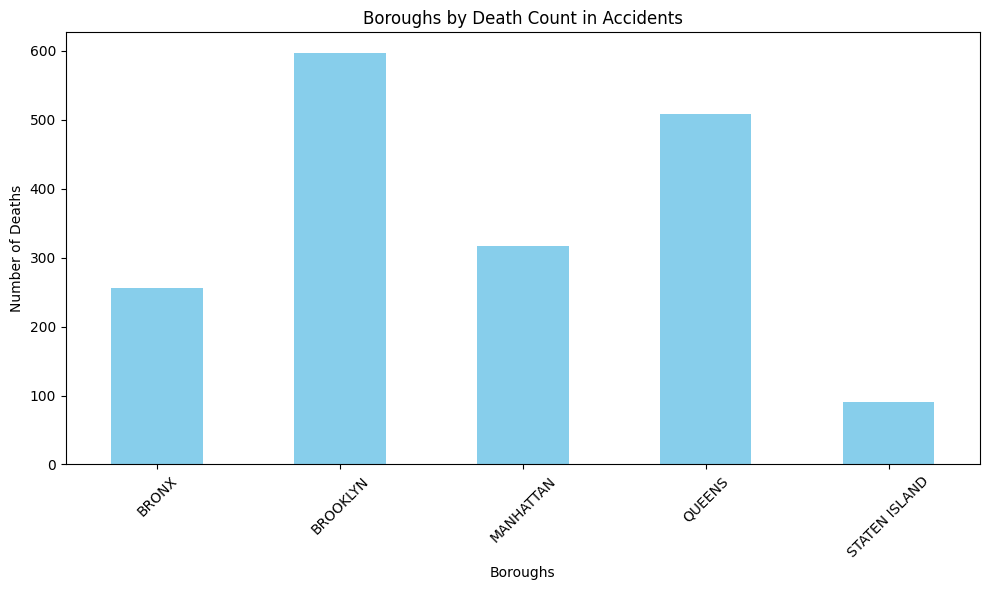

In [ ]:
def plot_borough_death_count(df):
    borough_death_counts = df.groupby(HelperClass.CrashColumns.BOROUGH.value)[HelperClass.CrashColumns.NUMBER_OF_PERSONS_KILLED.value].sum()

    plt.figure(figsize=(10, 6))
    borough_death_counts.plot(kind='bar', color='skyblue')
    plt.title('Boroughs by Death Count in Accidents')
    plt.xlabel('Boroughs')
    plt.ylabel('Number of Deaths')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_borough_death_count(mv_df)

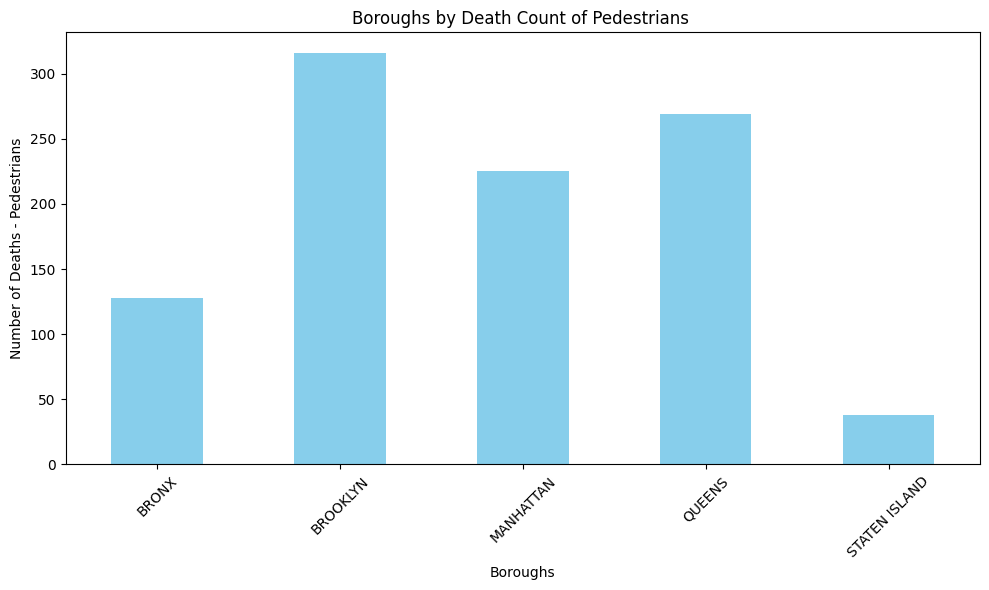

In [ ]:
def plot_borough_pedestrian_death_count(df):
    borough_death_counts = df.groupby(HelperClass.CrashColumns.BOROUGH.value)[HelperClass.CrashColumns.NUMBER_OF_PEDESTRIANS_KILLED.value].sum()

    plt.figure(figsize=(10, 6))
    borough_death_counts.plot(kind='bar', color='skyblue')
    plt.title('Boroughs by Death Count of Pedestrians ')
    plt.xlabel('Boroughs')
    plt.ylabel('Number of Deaths - Pedestrians')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_borough_pedestrian_death_count(mv_df)

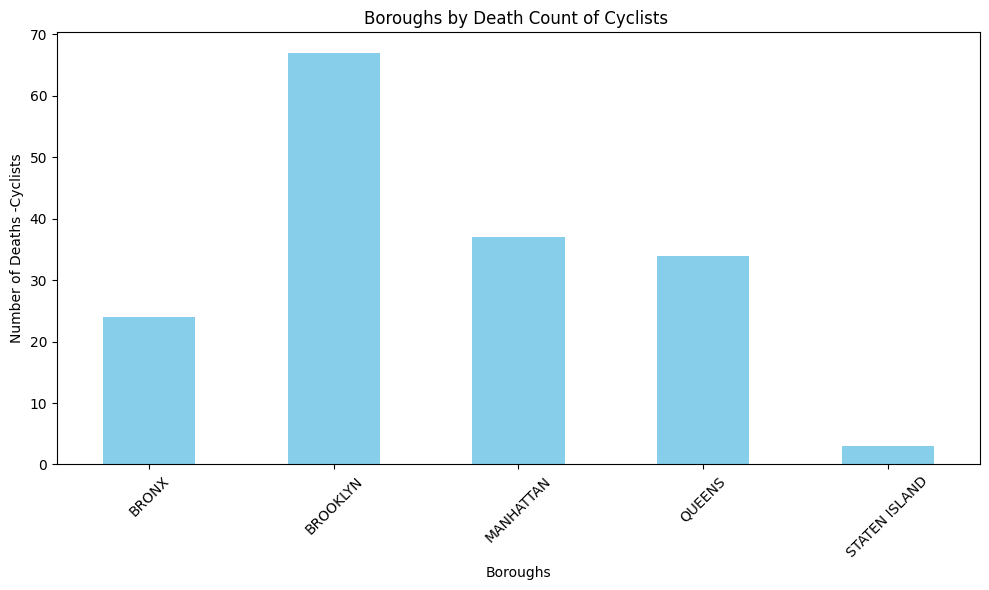

In [ ]:
def plot_borough_cyclists_death_count(df):
    borough_death_counts = df.groupby(HelperClass.CrashColumns.BOROUGH.value)[HelperClass.CrashColumns.NUMBER_OF_CYCLIST_KILLED.value].sum()

    plt.figure(figsize=(10, 6))
    borough_death_counts.plot(kind='bar', color='skyblue')
    plt.title('Boroughs by Death Count of Cyclists ')
    plt.xlabel('Boroughs')
    plt.ylabel('Number of Deaths -Cyclists')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_borough_cyclists_death_count(mv_df)

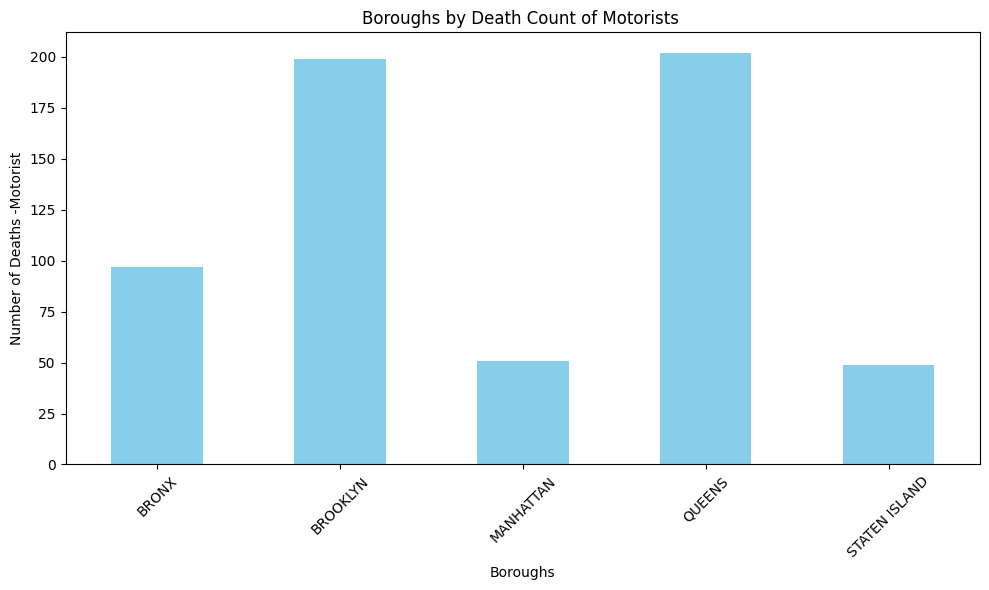

In [ ]:
def plot_borough_motorist_death_count(df):
    borough_death_counts = df.groupby(HelperClass.CrashColumns.BOROUGH.value)[HelperClass.CrashColumns.NUMBER_OF_MOTORIST_KILLED.value].sum()

    plt.figure(figsize=(10, 6))
    borough_death_counts.plot(kind='bar', color='skyblue')
    plt.title('Boroughs by Death Count of Motorists ')
    plt.xlabel('Boroughs')
    plt.ylabel('Number of Deaths -Motorist')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_borough_motorist_death_count(mv_df)

#### Bar Plot year_wise_death_count

In [ ]:
def year_wise_death_count(df,borough_name):
  """
    Plotting the trend of death count in accidents by year for a specific borough.

    Args:
    - df (pd.DataFrame): DataFrame containing accident data.
    - borough_name (str): Name of the borough to analyze.

    Returns:
    - Plot: Bar plot showing the trend of death count in accidents by year for the specified borough.

    Example:
    year_wise_death_count(accident_data, 'Manhattan')
  """
  temp_df = df[df[HelperClass.CrashColumns.BOROUGH.value]==borough_name]
  temp_df[HelperClass.CrashColumns.CRASH_DATE.value] = pd.to_datetime(temp_df[HelperClass.CrashColumns.CRASH_DATE.value])
  temp_df['year'] = temp_df[HelperClass.CrashColumns.CRASH_DATE.value].dt.year

  yearly_death_count = temp_df.groupby('year')[HelperClass.CrashColumns.NUMBER_OF_PERSONS_KILLED.value].sum()


  plt.figure(figsize=(10, 6))
  yearly_death_count.plot(kind='bar', color='skyblue')
  plt.title(f'Death Count Trend in {borough_name} Accidents (Year-wise)')
  plt.xlabel('Year')
  plt.ylabel('Number of Deaths')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()


<ipython-input-31-1baab5c3a926>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[HelperClass.CrashColumns.CRASH_DATE.value] = pd.to_datetime(temp_df[HelperClass.CrashColumns.CRASH_DATE.value])
<ipython-input-31-1baab5c3a926>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['year'] = temp_df[HelperClass.CrashColumns.CRASH_DATE.value].dt.year


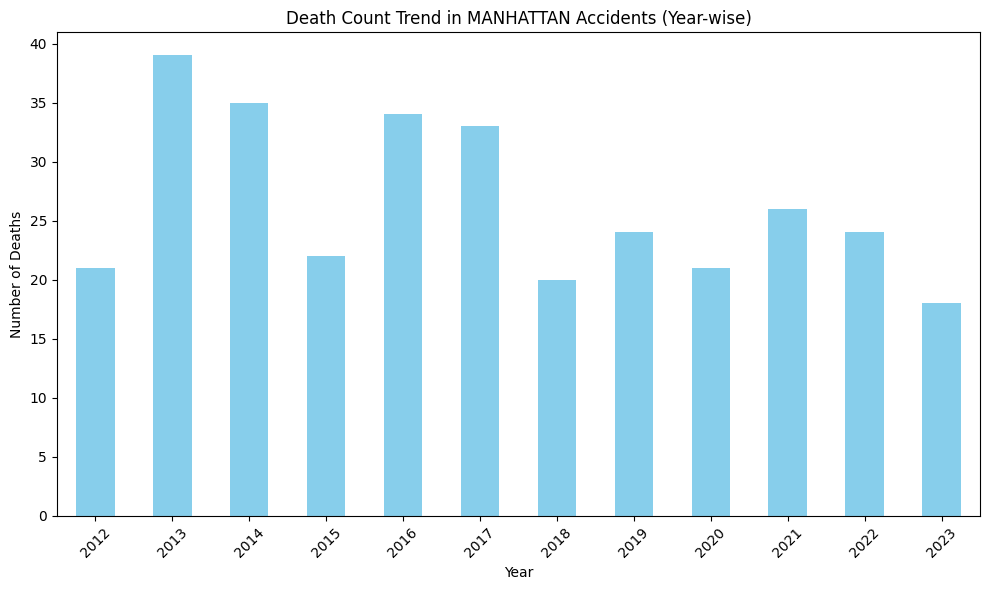

In [ ]:
year_wise_death_count(mv_df,HelperClass.NYC_Boroughs.MANHATTAN.value)

<ipython-input-31-1baab5c3a926>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[HelperClass.CrashColumns.CRASH_DATE.value] = pd.to_datetime(temp_df[HelperClass.CrashColumns.CRASH_DATE.value])
<ipython-input-31-1baab5c3a926>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['year'] = temp_df[HelperClass.CrashColumns.CRASH_DATE.value].dt.year


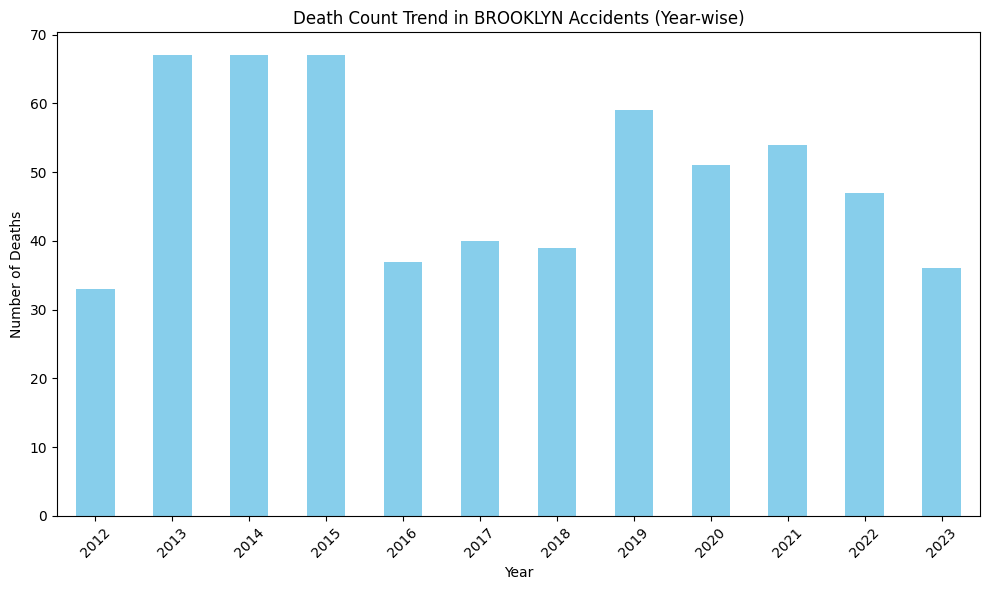

In [ ]:
year_wise_death_count(mv_df,HelperClass.NYC_Boroughs.BROOKLYN.value)

#### Plot: month_wise_death_count

In [ ]:
def month_wise_death_count(df,borough_name):
  """
    Plotting the trend of death count in accidents by month for a specific borough.

    Args:
    - df (pd.DataFrame): DataFrame containing accident data.
    - borough_name (str): Name of the borough to analyze.

    Returns:
    - Plot: Bar plot showing the trend of death count in accidents by month for the specified borough.

    Example:
    month_wise_death_count(accident_data, 'Manhattan')
  """
  temp_df = df[df[HelperClass.CrashColumns.BOROUGH.value]==borough_name]
  temp_df[HelperClass.CrashColumns.CRASH_DATE.value] = pd.to_datetime(temp_df[HelperClass.CrashColumns.CRASH_DATE.value])
  temp_df['month'] = temp_df[HelperClass.CrashColumns.CRASH_DATE.value].dt.month

  yearly_death_count = temp_df.groupby('month')[HelperClass.CrashColumns.NUMBER_OF_PERSONS_KILLED.value].sum()


  plt.figure(figsize=(10, 6))
  yearly_death_count.plot(kind='bar', color='skyblue')
  plt.title(f'Death Count Trend in {borough_name} Accidents (Month-wise)')
  plt.xlabel('Year')
  plt.ylabel('Number of Deaths')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()


<ipython-input-34-405712a68b4c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[HelperClass.CrashColumns.CRASH_DATE.value] = pd.to_datetime(temp_df[HelperClass.CrashColumns.CRASH_DATE.value])
<ipython-input-34-405712a68b4c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['month'] = temp_df[HelperClass.CrashColumns.CRASH_DATE.value].dt.month


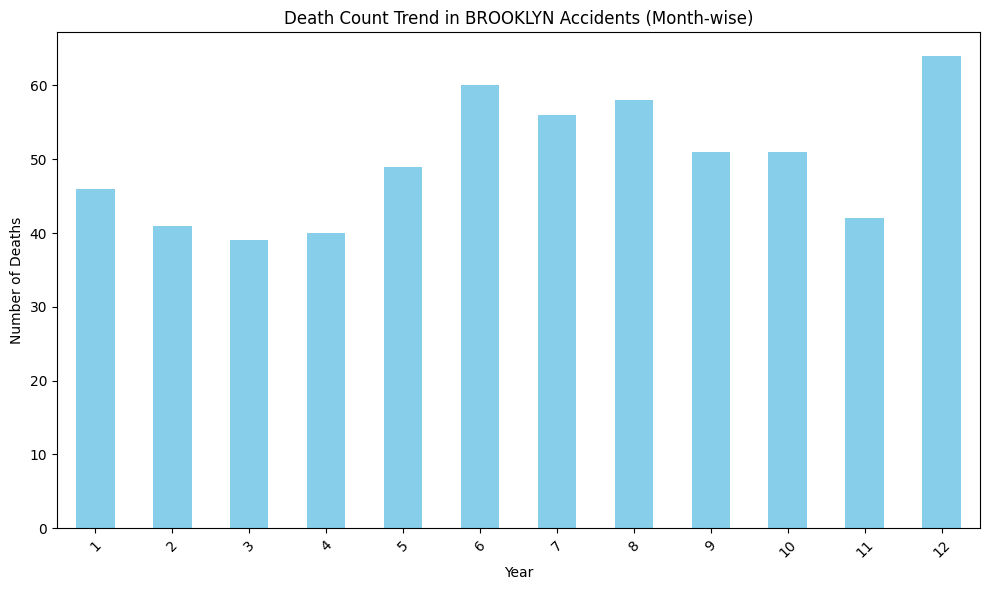

In [ ]:
month_wise_death_count(mv_df,HelperClass.NYC_Boroughs.BROOKLYN.value)

#### Death Count trend of pedestrians, cyclist, motorist

In [ ]:
def month_wise_pedes_motorist_cyclists_death_count(df,borough_name):
  """
    Plotting the trend of death count of pedestrians, cyclists, and motorists by month for a specific borough.

    Args:
    - df (pd.DataFrame): DataFrame containing accident data.
    - borough_name (str): Name of the borough to analyze.

    Returns:
    - Plot: Bar plot showing the trend of death count of pedestrians, cyclists, and motorists by month for the specified borough.

    Example:
    month_wise_pedes_motorist_cyclists_death_count(accident_data, 'Manhattan')
  """
  temp_df = df[df[HelperClass.CrashColumns.BOROUGH.value]==borough_name]
  temp_df[HelperClass.CrashColumns.CRASH_DATE.value] = pd.to_datetime(temp_df[HelperClass.CrashColumns.CRASH_DATE.value])
  temp_df['month'] = temp_df[HelperClass.CrashColumns.CRASH_DATE.value].dt.month

  yearly_death_count = temp_df.groupby('month')[[HelperClass.CrashColumns.NUMBER_OF_PEDESTRIANS_KILLED.value, HelperClass.CrashColumns.NUMBER_OF_CYCLIST_KILLED.value, HelperClass.CrashColumns.NUMBER_OF_MOTORIST_KILLED.value, ]].sum()


  plt.figure(figsize=(10, 6))
  yearly_death_count.plot(kind='bar')
  plt.title(f'Death Count Trend of Pedestrians,Cyclists, Motorists   in {borough_name} Accidents (Month-wise)')
  plt.xlabel('Year')
  plt.ylabel('Number of Deaths')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()


<ipython-input-36-eb2556b841eb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[HelperClass.CrashColumns.CRASH_DATE.value] = pd.to_datetime(temp_df[HelperClass.CrashColumns.CRASH_DATE.value])
<ipython-input-36-eb2556b841eb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['month'] = temp_df[HelperClass.CrashColumns.CRASH_DATE.value].dt.month


<Figure size 1000x600 with 0 Axes>

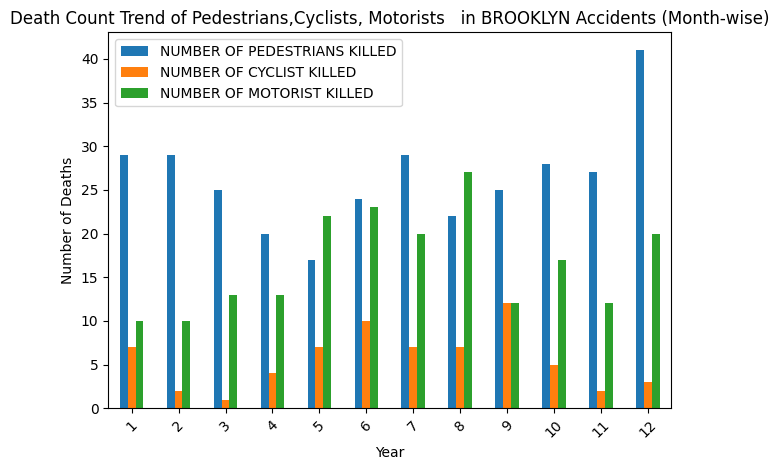

In [ ]:
month_wise_pedes_motorist_cyclists_death_count(mv_df,HelperClass.NYC_Boroughs.BROOKLYN.value)

In [ ]:
mv_df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_1.value].unique()

array(['Unspecified', 'Passing Too Closely', 'Driver Inexperience',
       'Passing or Lane Usage Improper', 'Turning Improperly',
       'Unsafe Speed', 'Reaction to Uninvolved Vehicle',
       'Steering Failure', 'Following Too Closely', 'Other Vehicular',
       'Driver Inattention/Distraction', 'Oversized Vehicle',
       'Traffic Control Disregarded', 'Unsafe Lane Changing',
       'Alcohol Involvement', 'View Obstructed/Limited',
       'Failure to Yield Right-of-Way', 'Aggressive Driving/Road Rage',
       'Pavement Slippery', 'Illnes', 'Lost Consciousness',
       'Brakes Defective', 'Backing Unsafely', 'Passenger Distraction',
       'Fell Asleep',
       'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
       'Obstruction/Debris', 'Tinted Windows', 'Animals Action',
       'Drugs (illegal)', 'Pavement Defective', 'Other Lighting Defects',
       'Outside Car Distraction', 'Driverless/Runaway Vehicle',
       'Tire Failure/Inadequate', 'Fatigued/Drowsy',
       'Headli

#### Bar plot: plot_boroughWise_accidentCause

In [ ]:
def plot_boroughWise_accidentCause(df,borough_name, killed_threshold=1):
  """
    Plotting the number of deaths per accident cause in a specific borough.

    Args:
    - df (pd.DataFrame): DataFrame containing accident data.
    - borough_name (str): Name of the borough to analyze.
    - killed_threshold (int): Threshold for the number of persons killed.

    Returns:
    - Plot: Bar plot showing the number of deaths per accident cause for the specified borough.

    Example:
    plot_boroughWise_accidentCause(accident_data, 'Manhattan', killed_threshold=2)
  """
  temp_df = df[(df[HelperClass.CrashColumns.BOROUGH.value] == borough_name) & (df[HelperClass.CrashColumns.NUMBER_OF_PERSONS_KILLED.value] >= killed_threshold) ]
  # temp_df.groupby(HelperClass.CrashColumns.BOROUGH.value)[HelperClass.CrashColumns.NUMBER_OF_PERSONS_KILLED.value].sum()
  cause_counts = temp_df.groupby(HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_1.value)[HelperClass.CrashColumns.NUMBER_OF_PERSONS_KILLED.value].count().reset_index()
  plt.figure(figsize=(10, 6))
  plt.bar(cause_counts[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_1.value], cause_counts[HelperClass.CrashColumns.NUMBER_OF_PERSONS_KILLED.value])
  plt.xlabel('Accident Cause')
  plt.ylabel('Number of Deaths')
  plt.title('Number of Deaths per Accident Cause')
  plt.xticks(rotation=90)  # Rotating x-axis labels for better readability if needed
  plt.tight_layout()
  plt.show()


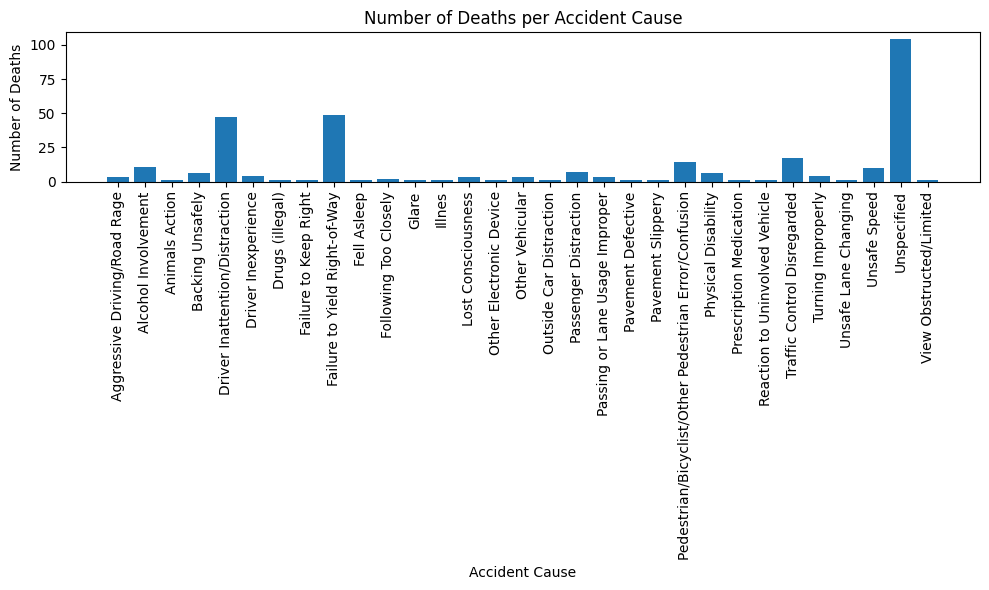

In [ ]:
plot_boroughWise_accidentCause(mv_df,HelperClass.NYC_Boroughs.MANHATTAN.value)

#### Bar Plot: plot_boroughWise_accidentCause, after dropping unspecified reasons

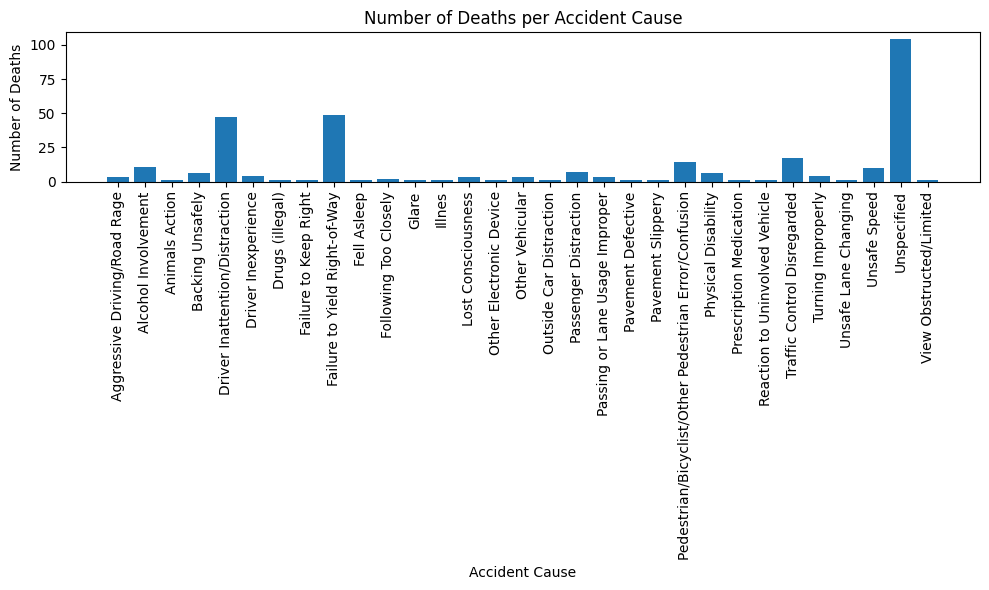

In [ ]:
plot_boroughWise_accidentCause(mv_df,HelperClass.NYC_Boroughs.MANHATTAN.value)

In [ ]:
mv_df.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'STRTNAME_BOROUGH', 'Neighboorhood'],
      dtype='object')

In [ ]:
mv_df['Neighboorhood'].unique()

array(['Central Brooklyn', nan, 'Flatbush', 'Southwest Queens',
       'Northwest Queens', 'Gramercy Park and Murray Hill',
       'Southeast Queens', 'Borough Park', 'Mid-Island',
       'Canarsie and Flatlands', 'Upper East Side', 'Jamaica',
       'Inwood and Washington Heights', 'Upper West Side',
       'West Central Queens', 'Bronx Park and Fordham',
       'Hunts Point and Mott Haven', 'Greenwich Village and Soho',
       'Greenpoint', 'East New York and New Lots', 'Northwest Brooklyn',
       'Central Harlem', 'Rockaways', 'Southern Brooklyn',
       'Southeast Bronx', 'Central Queens', 'South Shore', 'West Queens',
       'Central Bronx', 'Bushwick and Williamsburg',
       'Chelsea and Clinton', 'Southwest Brooklyn', 'East Harlem',
       'Northeast Bronx', 'North Queens', 'Sunset Park',
       'Stapleton and St. George', 'Lower East Side',
       'High Bridge and Morrisania', 'Northeast Queens',
       'Lower Manhattan', 'Port Richmond', 'Kingsbridge and Riverdale'],
      d

In [ ]:
def plot_boroughWise_accidentCause(df,borough_name, killed_threshold=1,drop_unspecified=True):
  if drop_unspecified:
    df.drop(df[ (df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_1.value] == 'Unspecified') | (df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_2.value] == 'Unspecified') ].index, inplace=True)

  temp_df = df[(df[HelperClass.CrashColumns.BOROUGH.value] == borough_name) & (df[HelperClass.CrashColumns.NUMBER_OF_PERSONS_KILLED.value] >= killed_threshold) ]
  cause_counts_cf1 = temp_df.groupby(HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_1.value)[HelperClass.CrashColumns.NUMBER_OF_PERSONS_KILLED.value].sum().reset_index()

  cause_counts_cf2 = temp_df.groupby(HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_2.value)[HelperClass.CrashColumns.NUMBER_OF_PERSONS_KILLED.value].sum().reset_index()


  cause_counts_cf1.columns = ['final_accident_contributing_factor', 'final_killed_count']
  cause_counts_cf2.columns = ['final_accident_contributing_factor', 'final_killed_count']

  merged_causes = pd.concat([cause_counts_cf1, cause_counts_cf2]).groupby('final_accident_contributing_factor').sum().reset_index()




  plt.figure(figsize=(10, 6))
  plt.bar(merged_causes['final_accident_contributing_factor'], merged_causes['final_killed_count'])
  plt.xlabel('Accident Cause')
  plt.ylabel('Number of Deaths')
  plt.title(f'Number of Deaths in {borough_name} per Accident Cause')
  plt.xticks(rotation=90)  # Rotating x-axis labels for better readability if needed
  plt.tight_layout()
  plt.show()


#### Bar Plot:  Neighboorhood-wise

In [ ]:
import plotly.express as px

def plot_neWise_accidentCause_plotly(df, neighborhood_name, drop_unspecified=True):
    """
    Plotting the number of accidents per accident cause in a specific neighborhood.

    Args:
    - df (pd.DataFrame): DataFrame containing accident data.
    - neighborhood_name (str): Name of the neighborhood to analyze.
    - drop_unspecified (bool): Flag to drop 'Unspecified' contributing factors.

    Returns:
    - Plot: Bar plot showing the number of accidents per accident cause for the specified neighborhood.
    - DataFrame: Counts of accidents per contributing factor for the neighborhood.

    Example:
    plot_neWise_accidentCause(accident_data, 'Queens', drop_unspecified=True)
    """
    if drop_unspecified:
        df.drop(df[
            (df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_1.value] == 'Unspecified') |
            (df[HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_2.value] == 'Unspecified')
        ].index, inplace=True)

    temp_df = df[df[HelperClass.CrashColumns.NEIGHBORHOOD.value] == neighborhood_name]
    cause_counts_cf1 = temp_df.groupby(HelperClass.CrashColumns.CONTRIBUTING_FACTOR_VEHICLE_1.value).size().reset_index()
    cause_counts_cf1.columns = ['final_accident_contributing_factor', 'final_killed_count']

    # Plotting using Plotly
    fig = px.bar(cause_counts_cf1, x='final_accident_contributing_factor', y='final_killed_count',
                 labels={'final_accident_contributing_factor': 'Accident Cause', 'final_killed_count': 'Number of Accidents'},
                 title=f'Number of Accidents in {neighborhood_name} per Accident Cause')
    fig.update_xaxes(tickangle=90)  # Rotating x-axis labels for better readability if needed
    fig.show()

    return cause_counts_cf1


In [ ]:
neighboord_name = "Greenpoint"
cause_counts_df = plot_neWise_accidentCause_plotly(mv_df,neighboord_name)
cause_counts_dict = dict(zip(cause_counts_df['final_accident_contributing_factor'], cause_counts_df['final_killed_count']))
dict_string = str(cause_counts_dict)
